In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf, report, psth_foraging
from pipeline.plot import behavior_plot, unit_characteristic_plot, unit_psth, histology_plot, PhotostimError, foraging_plot
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice, plot_unit_all_in_one

foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol=100').proj()
import datajoint as dj; dj.conn().connect()

cache_folder = '~/s3-drive/report/st_cache/'

/home/jupyter/map-ephys


[2023-02-10 22:54:31,043][INFO]: Connecting map-superuser@datajoint.mesoscale-activity-map.org:3306
[2023-02-10 22:54:31,101][INFO]: Connected map-superuser@datajoint.mesoscale-activity-map.org:3306


# Get meta info

In [23]:
foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol in (100, 110, 120)').proj()
if_photostim_from_behav = foraging_sessions.aggr(foraging_sessions * experiment.PhotostimForagingTrial, ...,
                                      keep_all_rows=True, photostim_behav='IF(COUNT(trial)>0, "yes", "no")')
if_photostim_from_ephys = foraging_sessions.aggr(foraging_sessions * (ephys.TrialEvent & 'trial_event_type LIKE "laser%"'), ...,
                                      keep_all_rows=True, photostim_NI='IF(COUNT(trial)>0, "yes", "no")')

q = ((experiment.Session & foraging_sessions)
                            * lab.WaterRestriction.proj(h2o='water_restriction_number')
                            * if_photostim_from_behav
                            * if_photostim_from_ephys
    & 'photostim_behav = "yes"').proj(..., '-rig', '-username', '-session_time')
df_sessions = pd.DataFrame(q.fetch())
photostim_behavior = df_sessions.query('photostim_behav == "yes"')
photostim_behavior

,subject_id,session,session_date,h2o,photostim_behav,photostim_NI
0,494691,19,2021-12-10,HH16,yes,no
1,494694,21,2021-12-16,HH18,yes,yes
2,494694,20,2021-12-15,HH18,yes,yes
3,494694,19,2021-12-14,HH18,yes,yes
4,494694,18,2021-12-13,HH18,yes,yes
...,...,...,...,...,...,...
74,646196,41,2023-02-01,XY_09,yes,no
75,646196,40,2023-01-31,XY_09,yes,no
76,646196,39,2023-01-30,XY_09,yes,no
77,646196,38,2023-01-27,XY_09,yes,no


In [28]:
q_xy_10 = q & 'h2o = "XY_10"'
q_xy_10

subject_id institution 6 digit animal ID,session session number,session_date,h2o WR number,photostim_behav calculated attribute,photostim_NI calculated attribute
643252,41,2023-02-09,XY_10,yes,no
643252,40,2023-02-08,XY_10,yes,no
643252,39,2023-02-07,XY_10,yes,no
643252,38,2023-02-02,XY_10,yes,no
643252,37,2023-02-01,XY_10,yes,no
643252,36,2023-01-31,XY_10,yes,no
643252,35,2023-01-30,XY_10,yes,no
643252,34,2023-01-27,XY_10,yes,no
643252,33,2023-01-26,XY_10,yes,no
643252,32,2023-01-25,XY_10,yes,no


{'subject_id': 643252, 'session': 23}


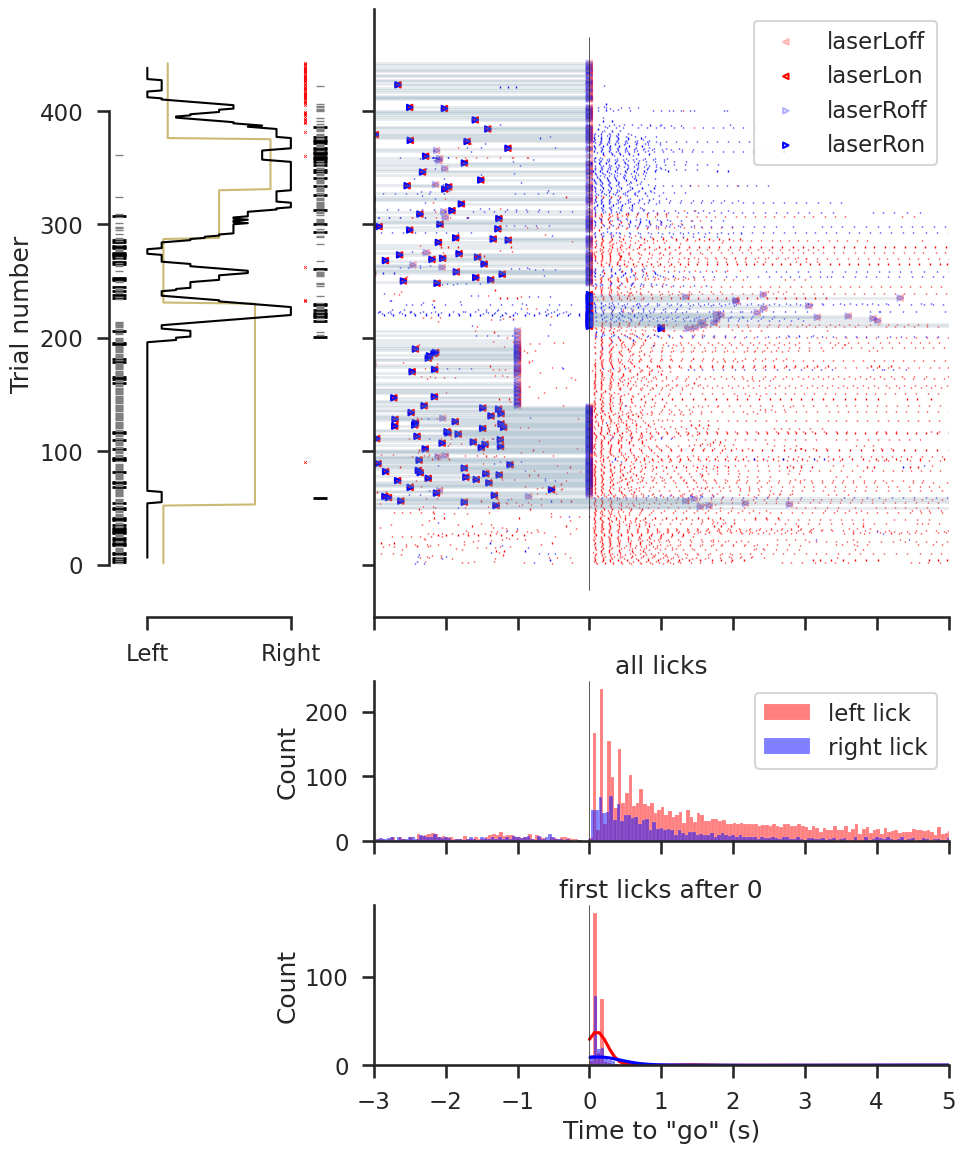

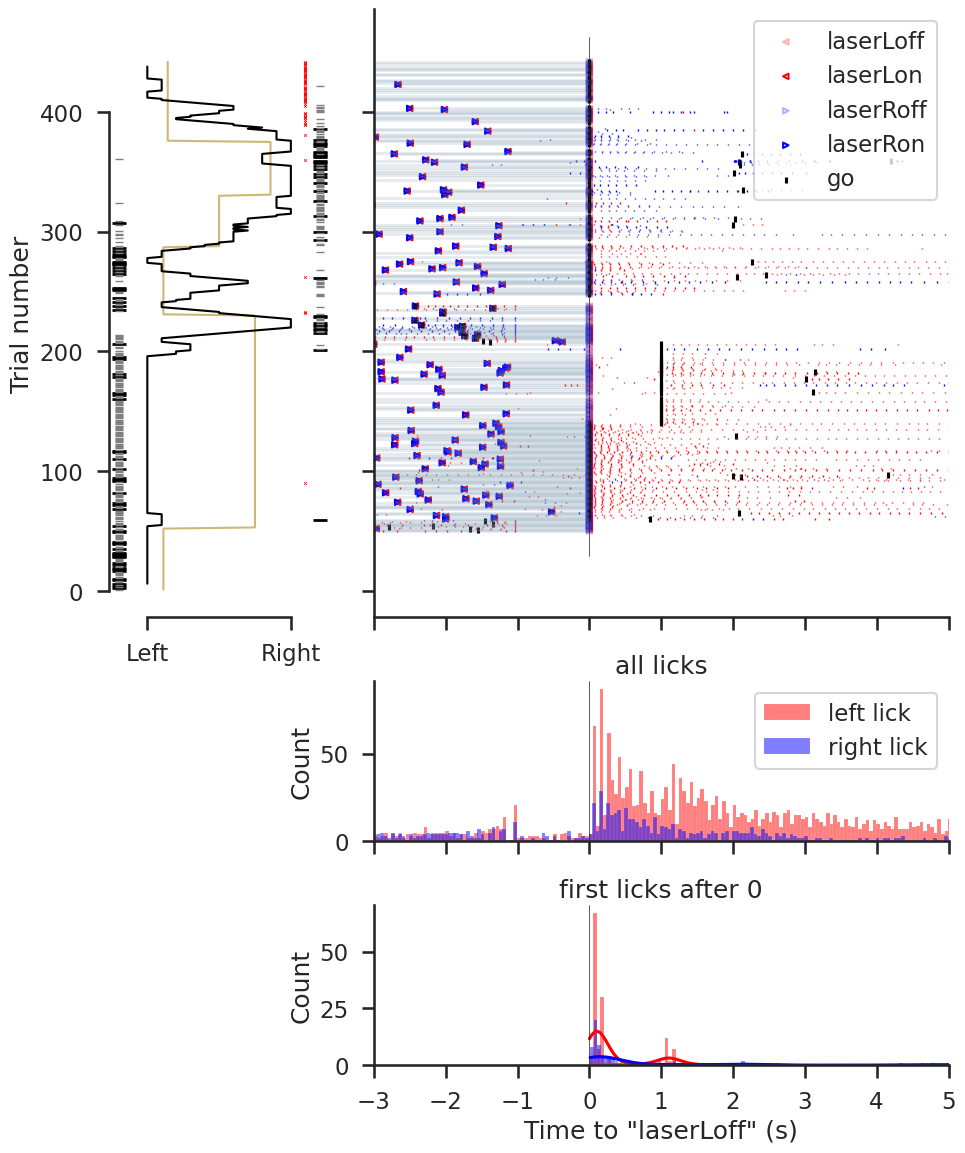

{'subject_id': 643252, 'session': 24}


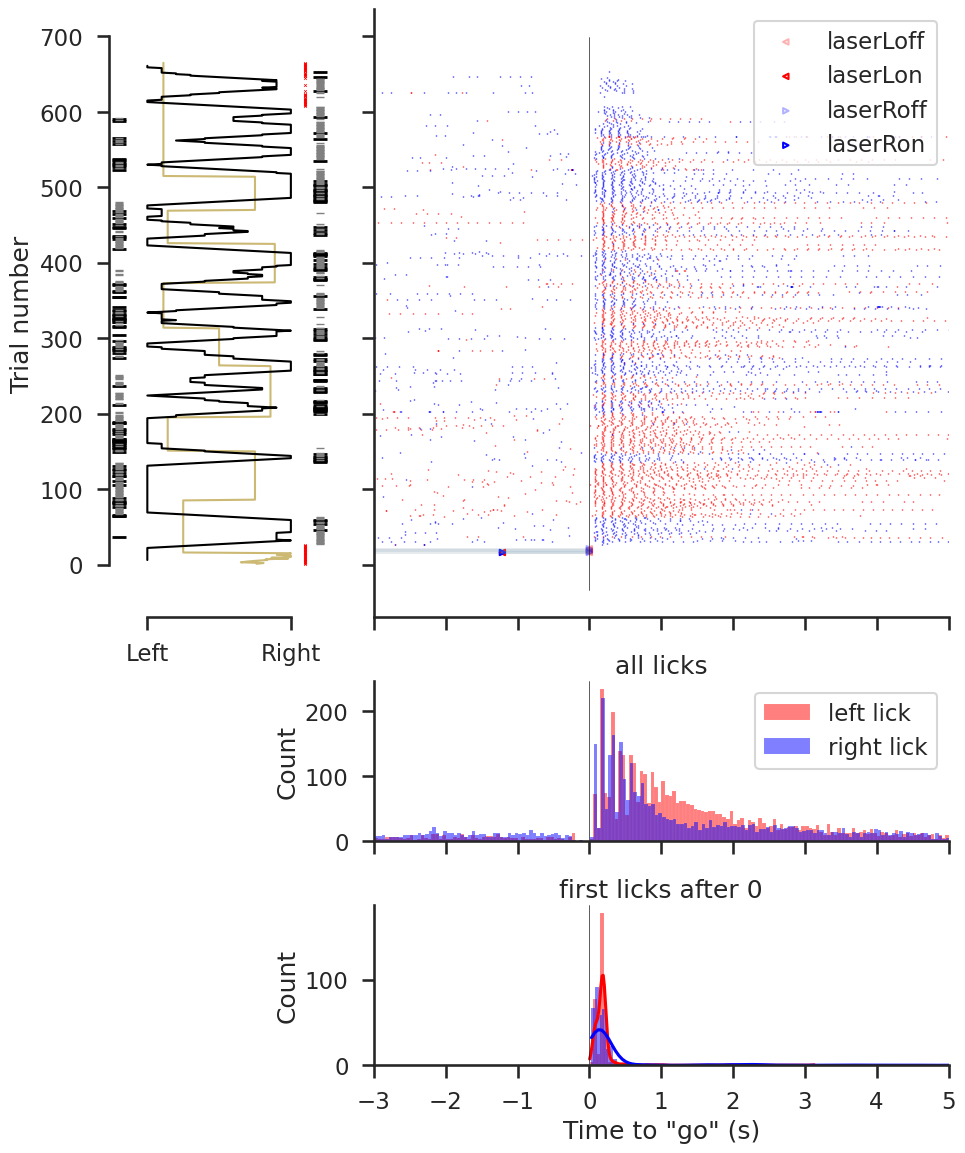

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


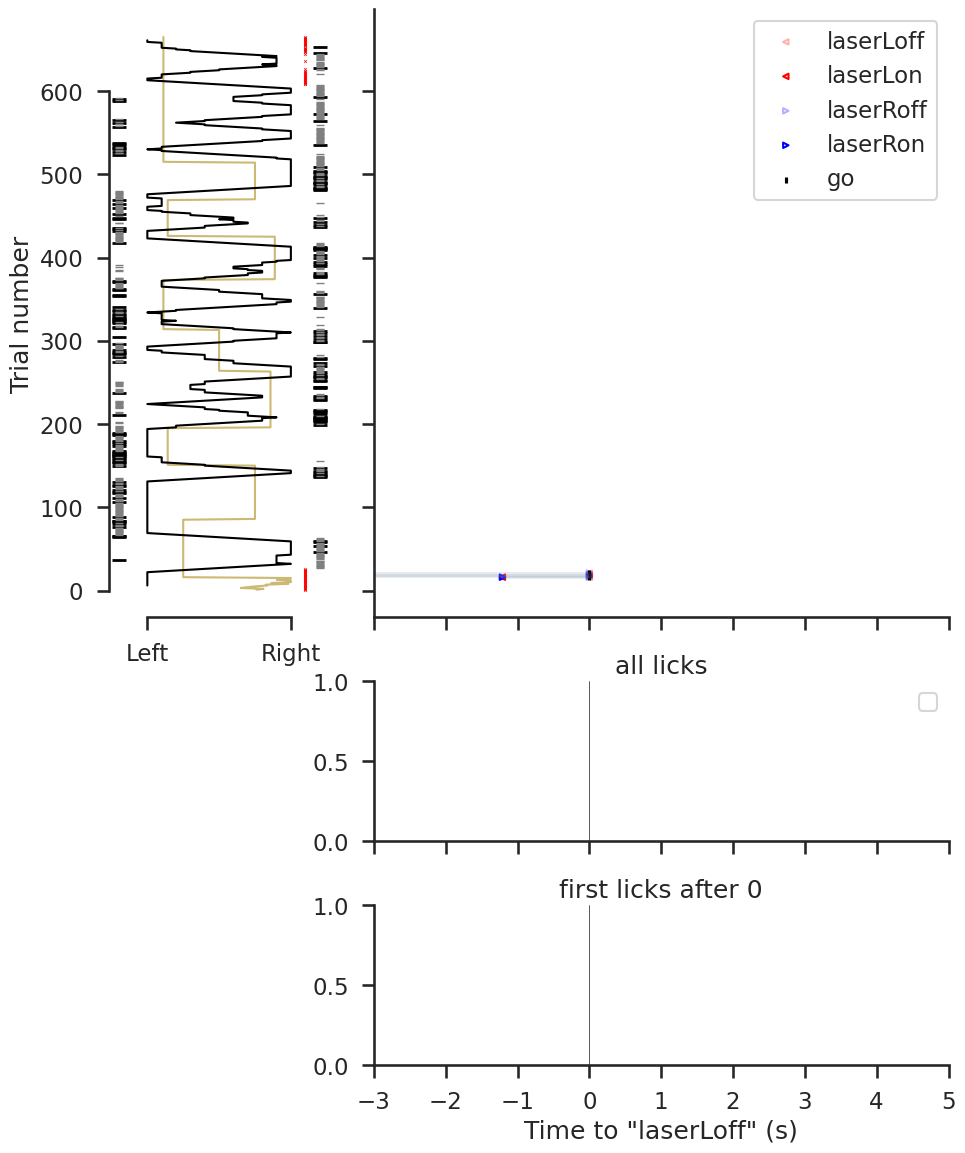

In [115]:
for key in q_xy_10.fetch('KEY', order_by='session')[:2]:
    print(key)
    foraging_plot.plot_lick_psth(key)
    foraging_plot.plot_lick_psth(key, trial_event_to_align='laserLoff', other_trial_events={'laserLoff': ('None', '<'), 'laserLon': ('None', '<'), 'laserRoff': ('None', '>'), 'laserRon': ('None', '>'), 'go': ('black', '|')})

# Session-wise

## Event plot

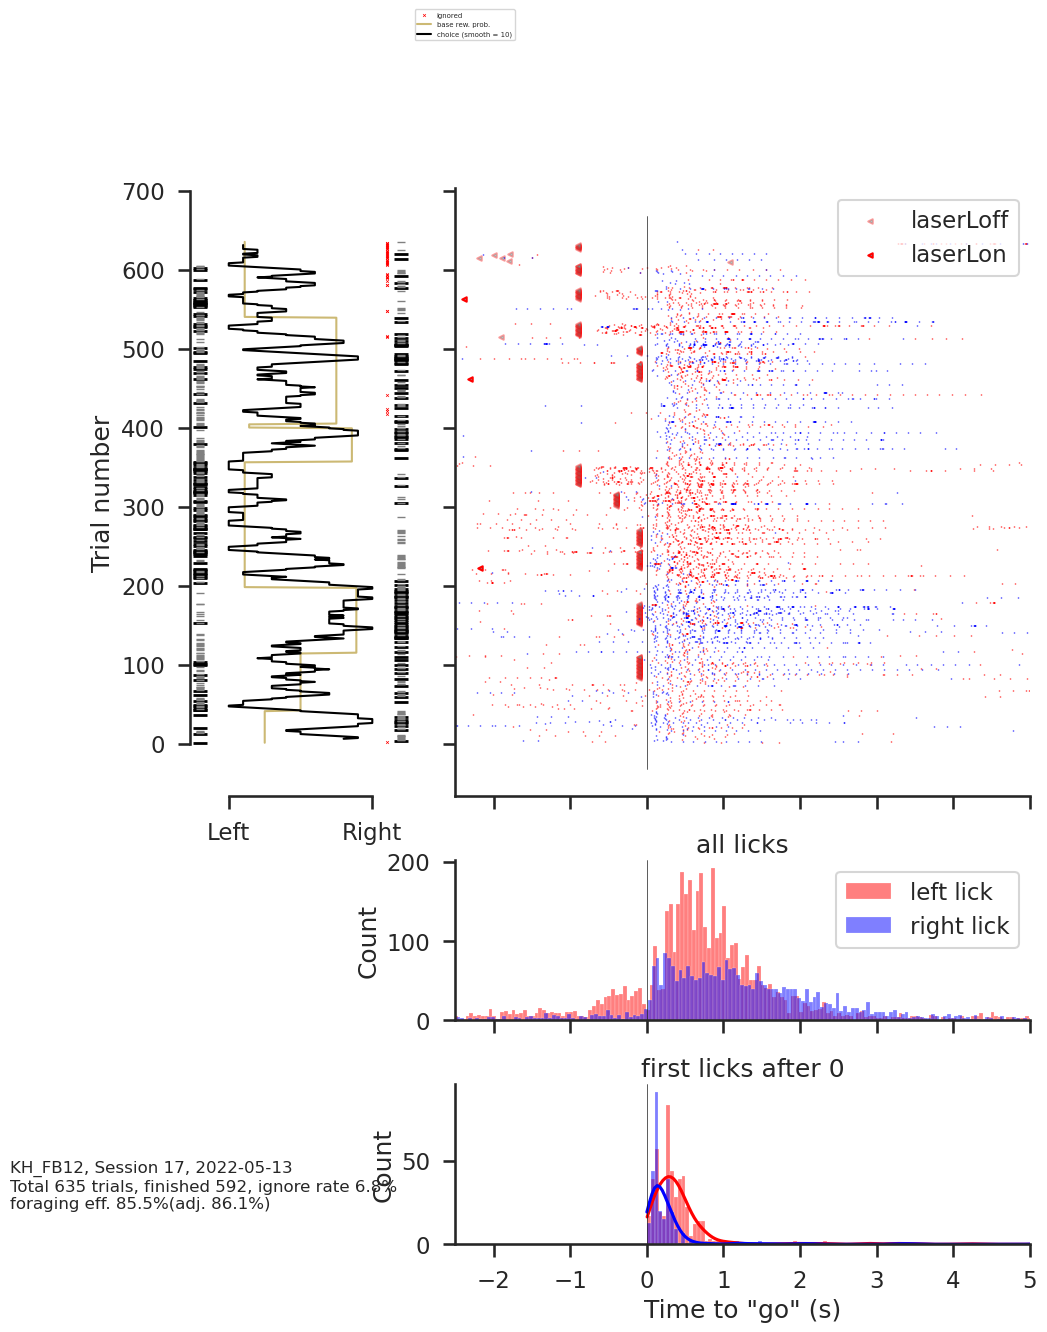

In [4]:
foraging_plot.plot_lick_psth(dict(subject_id=616134, session=17))